In [1]:
from lstmad.vrae import VRAE
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import copy

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from lstmad.lstmae import RecurrentAutoencoder, train_model

import matplotlib.pyplot as plt

RANDOM_SEED = 666

### Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
hidden_size = 90
hidden_layer_depth = 1
latent_length = 20
batch_size = 32
learning_rate = 0.0005
n_epochs = 40
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Load data

In [4]:
train_df = pd.read_csv('data/ECG5000_TRAIN.txt',
                       sep=' ',skipinitialspace=True,
                       header=None,
                       names=['target'] + list(range(0,140)))

test_df = pd.read_csv('data/ECG5000_TEST.txt',
                       sep=' ',skipinitialspace=True,
                       header=None,
                       names=['target'] + list(range(0,140)))

In [5]:
df = train_df.append(test_df)
df = df.sample(frac=1.0)
df.target -=1
y = df['target']
X = df.drop(labels='target', axis=1)
y = (y>1.0).astype(int)

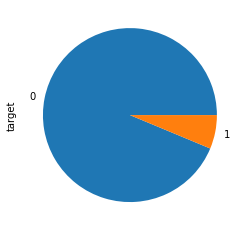

In [6]:
y.value_counts().plot.pie()

In [7]:
train_X, val_X, train_y, val_y = train_test_split(
  X, y,
  test_size=0.3,
  random_state=RANDOM_SEED
)

val_X, test_X, val_y, test_y = train_test_split(
  val_X, val_y,
  test_size=0.5, 
  random_state=RANDOM_SEED
)

In [8]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [9]:
train_dataset, seq_len, n_features = create_dataset(train_X)
val_dataset, _, _ = create_dataset(val_X)
test_dataset, _, _ = create_dataset(test_X)


In [10]:
model = RecurrentAutoencoder(seq_len, n_features, device, 8)
model = model.to(device)

In [11]:
# train_model(model,train_dataset,val_dataset, 50 , device)
# torch.save(model.state_dict(), 'autoencoder.pkl')

In [12]:
model.load_state_dict(torch.load('autoencoder.pkl'))

<All keys matched successfully>

In [13]:
train_errors, validation_errors, test_errors = [], [], []
train_dataset_np, val_dataset_np, test_dataset_np = [], [], []
loss_f = torch.nn.L1Loss(reduction='sum').to(device)
model = model.eval()


with torch.no_grad():
    
    for seq_true in train_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        train_errors.append(loss.item())
        train_dataset_np.append(z.cpu().numpy().reshape(-1))
    
    for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        validation_errors.append(loss.item())
        val_dataset_np.append(z.cpu().numpy().reshape(-1))
        
    for seq_true in test_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        test_errors.append(loss.item())
        test_dataset_np.append(z.cpu().numpy().reshape(-1))

train_errors = np.array(train_errors)
validation_errors = np.array(validation_errors)
test_errors = np.array(test_errors)

train_dataset_np = np.array(train_dataset_np)
val_dataset_np = np.array(val_dataset_np)
test_dataset_np = np.array(test_dataset_np)

61.002004226743736

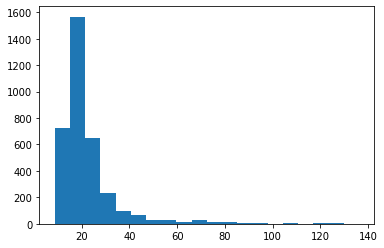

In [14]:
plt.hist(train_errors,bins=20)
train_errors.mean() + 3 * train_errors.std()

56.6163413693754

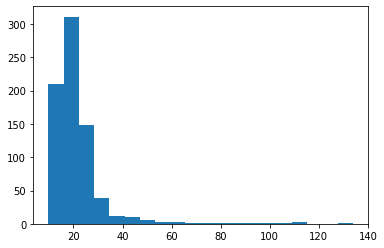

In [15]:
plt.hist(validation_errors,bins=20)
validation_errors.mean() + 3 * validation_errors.std()

55.88349517288043

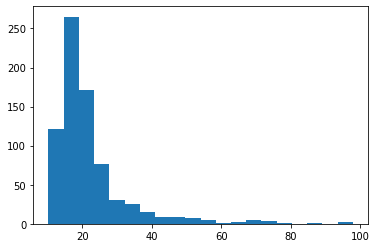

In [16]:
plt.hist(test_errors,bins=20)
test_errors.mean() + 3 * test_errors.std()

In [17]:
val_y.values[validation_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [18]:
test_y.values[test_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

In [19]:
train_y.values[train_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [20]:
# class AnomalyScoreProcessor(nn.Module):

#     def __init__(self, autoencoder, autoencoder_latent_dim, hidden_layer_dim, device):
#         super(AnomalyScoreProcessor, self).__init__()
#         self.autoencoder = autoencoder
#         for param in autoencoder.parameters():
#             param.requires_grad = False
#         self.hidden_layer_dim = hidden_layer_dim
#         self.hidden_layer = torch.nn.Linear(autoencoder_latent_dim + 1 , hidden_layer_dim).to(device)
#         self.relu = torch.nn.ReLU().to(device)
#         self.loss = nn.L1Loss(reduction='sum').to(device)

#     def forward(self, x):
#         z, out =  self.autoencoder(x)
#         anomaly_score = torch.abs(self.loss(out, x))
#         concatenated_tensor = torch.cat((z, anomaly_score.reshape(1, 1)), dim=1)
#         h = self.hidden_layer(concatenated_tensor)
#         rel = self.relu(h)
#         return rel

# class ExtendedAnomalyDetector(nn.Module):
    
#     def __init__(self, anomaly_score_processor, anomaly_score_processor_dim, class_nr, device):
#         super(ExtendedAnomalyDetector, self).__init__()
#         self.anomaly_score_processor = anomaly_score_processor
#         self.output_layer = torch.nn.Linear(anomaly_score_processor_dim, class_nr).to(device)
#         self.softmax = torch.nn.Softmax().to(device)
        
    
#     def forward(self, x):
#         out = self.anomaly_score_processor(x)
#         h = self.output_layer(out)
#         return self.softmax(h)
   

In [21]:
# asp = AnomalyScoreProcessor(model, 8, 4, device)
# ead = ExtendedAnomalyDetector(asp, 4, 2, device)

In [22]:
# def train_extended_anomaly_detector(model, x_train, y_train, x_val, y_val, n_epochs):
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     criterion = nn.CrossEntropyLoss().to(device)
#     history = dict(train=[], val=[])
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_loss = 10000.0
#     for epoch in range(1, n_epochs + 1):
#         model = model.train()
#         train_losses = []
#         for seq, y in zip(x_train, y_train):
#             optimizer.zero_grad()
#             seq = seq.to(device)
#             pred = model(seq)
#             #print(y)
#             loss = criterion(pred, torch.tensor(y).reshape(1).to(device))
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())
#         val_losses = []
#         model = model.eval()
#         with torch.no_grad():
#             for seq, y in zip(x_val, y_val):
#                 seq = seq.to(device)
#                 pred = model(seq)
#                 class_val = int(y>1)
#                 loss = criterion(pred, torch.tensor(class_val).reshape(1).to(device))
#                 val_losses.append(loss.item())
#         train_loss = np.mean(train_losses)
#         val_loss = np.mean(val_losses)
#         history['train'].append(train_loss)
#         history['val'].append(val_loss)
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model_wts = copy.deepcopy(model.state_dict())
#         print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
#     model.load_state_dict(best_model_wts)
#     return model.eval(), history

## Initial baseline

In [23]:
anomaly_threshold = train_errors.mean() + 3 * train_errors.std()
loss_f = torch.nn.L1Loss(reduction='sum').to(device)
model = model.eval()
losses = []
zs = []
training_y = []
with torch.no_grad():
    for seq_true in train_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        losses.append(loss.cpu().numpy())
        zs.append(z.cpu().numpy().reshape(-1))

In [24]:
indices = np.argsort(losses)
sorted_losses = [losses[i] for i in indices]

In [60]:
i = len(sorted_losses) - 1 
while sorted_losses[i] > anomaly_threshold:
    i-=1
anomalies_cnt = len(sorted_losses) - 1 - i
normal_data_index = i - anomalies_cnt
normal_indices = indices[normal_data_index:i]
anomaly_indices = indices[i:]

artificial_train_dataset_X=[]
artificial_train_dataset_X_numpy=[]
artificial_train_dataset_y=[]
labels = []

for idx in normal_indices:
    complete_vector = np.hstack([zs[idx],losses[idx]])
    vector = zs[idx]
    artificial_train_dataset_X_numpy.append(vector)
    artificial_train_dataset_X.append(train_dataset[idx])
    artificial_train_dataset_y.append(0)
    labels.append(train_y.iloc[idx])

for idx in anomaly_indices:
    complete_vector = np.hstack([zs[idx],losses[idx]])
    vector = zs[idx]
    artificial_train_dataset_X_numpy.append(vector)
    artificial_train_dataset_X.append(train_dataset[idx])
    artificial_train_dataset_y.append(1)
    labels.append(train_y.iloc[idx])
artificial_train_dataset_y = pd.Series(artificial_train_dataset_y)

artificial_train_dataset_X_numpy = np.array(artificial_train_dataset_X_numpy)
artificial_train_dataset_y = np.array(artificial_train_dataset_y)
artificial_train_dataset_X_numpy_backup = artificial_train_dataset_X_numpy.copy()
artificial_train_dataset_y_backup = artificial_train_dataset_y.copy()

In [56]:
artificial_train_dataset_y.value_counts()

1    92
0    91
dtype: int64

In [27]:
#train_extended_anomaly_detector(ead, artificial_train_dataset_X, artificial_train_dataset_y, val_dataset, val_y,50)

In [28]:
# preds = []
# ead = ead.eval()
# with torch.no_grad():    
#     for seq in artificial_train_dataset_X:
#         seq = seq.to(device)
#         pred = ead(seq)
#         pred = np.argmax(pred.cpu().numpy())
#         preds.append(pred)
# preds = pd.Series(preds)
# sum(artificial_train_dataset_y == preds)/len(preds)

# Classical models

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score

In [61]:
artificial_train_dataset_X_numpy = artificial_train_dataset_X_numpy_backup.copy()
artificial_train_dataset_y = artificial_train_dataset_y_backup.copy()

In [31]:
def evaluate(classical_model, dataset_x, dataset_y, verbose = True):
    pred = classical_model.predict_proba(dataset_x)
    preds = np.argmax(pred,axis=1)

    auprc = average_precision_score(dataset_y, np.max(pred, axis=1))
    auroc = roc_auc_score(dataset_y, np.max(pred, axis=1))
    recall = recall_score(dataset_y, np.argmax(pred, axis=1))
    precision = precision_score(dataset_y, np.argmax(pred, axis=1))
    if verbose:
        print(f'Recall: {recall}, precision: {precision}')
        print(f'AUROC: {auroc}, AUPRC {auprc}')
    return recall, precision, auroc, auprc

def evaluate_all(classical_model,
                 artificial_train_dataset_X, artificial_dataset_y,
                 train_dataset_X, train_dataset_y,
                 val_dataset_X, val_dataset_y,
                 test_dataset_X, test_dataset_y,
                 iteration_number = 0
                ):
    results = []
    dataset_types = ['artificial_train', 'train', 'val', 'test']
    datasets = [(artificial_train_dataset_X, artificial_train_dataset_y),
                (train_dataset_X, train_dataset_y), (val_dataset_X, val_dataset_y),
                (test_dataset_X, test_dataset_y)]
    for dataset_type, (x, y) in zip(dataset_types, datasets):
        recall, prec, auroc, auprc = evaluate(classical_model, x, y, verbose=False)
        results.append({'dataset_type': dataset_type, 'recall': recall,'precision': prec, 'auroc': auroc, 'auprc': auprc, 'iteration': iteration_number})
    return pd.DataFrame(results)

## LSTM-AD

In [32]:
train_pred = np.array(train_errors) > anomaly_threshold
val_pred = np.array(validation_errors) > anomaly_threshold
test_pred = np.array(test_errors) > anomaly_threshold

pd.DataFrame([
    {'dataset_type': 'train', 'recall': recall_score(train_y, train_pred), 'precision': precision_score(train_y, train_pred)},
    {'dataset_type': 'val', 'recall': recall_score(val_y, val_pred), 'precision': precision_score(val_y, val_pred)},
    {'dataset_type': 'test', 'recall': recall_score(test_y, test_pred), 'precision': precision_score(test_y, test_pred)},
    
    
])

,dataset_type,recall,precision
0,train,0.136986,0.329670
1,val,0.104167,0.416667
2,test,0.042553,0.133333


In [246]:
recall = 0.042553
precision = 0.1333

f1 = (recall*precision)/(recall+precision)
f1

0.03225600302525405

In [180]:
classical_models = []

## SVM

In [181]:
from sklearn.svm import SVC
classical_model = SVC(probability=True, class_weight={0:1, 1: 10})
classical_models.append(('SVM', classical_model))

## KNN

In [182]:
from sklearn.neighbors import KNeighborsClassifier
classical_model = KNeighborsClassifier(n_neighbors=4)
classical_models.append(('KNN', classical_model))

## LogisticRegression


In [183]:
from sklearn.linear_model import LogisticRegression
classical_model = LogisticRegression(max_iter=100)
classical_models.append(('LogReg', classical_model))

## Decision tree

In [184]:
from sklearn.tree import DecisionTreeClassifier
classical_model = DecisionTreeClassifier(max_depth=5)
classical_models.append(('DT', classical_model))

## Naive Bayes

In [185]:
from sklearn.naive_bayes import GaussianNB
classical_model = GaussianNB()
classical_models.append(('NB', classical_model))

# Active learning loop

In [163]:
AL_BATCH_SIZE = 10
iterations = 30

In [164]:
results = pd.DataFrame()
for model_type, model in classical_models:
    artificial_train_dataset_X_numpy = artificial_train_dataset_X_numpy_backup.copy()
    artificial_train_dataset_y = artificial_train_dataset_y_backup.copy()
    model.fit(artificial_train_dataset_X_numpy, artificial_train_dataset_y)
    res = evaluate_all(model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
                       train_dataset_np, train_y, val_dataset_np, val_y,
                       test_dataset_np, test_y)
    res['model_type'] = model_type
    results.append(res)
    for iteration in range(1, iterations):
        scores = model.predict_proba(train_dataset_np)
        indices = np.argsort(np.abs(scores[:,0] - scores[:, 1]))
        to_query = indices[:AL_BATCH_SIZE]
        new_X = train_dataset_np[to_query]
        new_y = np.array(train_y)[to_query]

        artificial_train_dataset_X_numpy = np.vstack([artificial_train_dataset_X_numpy, new_X])
        artificial_train_dataset_y = np.hstack([artificial_train_dataset_y, new_y])
        model.fit(artificial_train_dataset_X_numpy, artificial_train_dataset_y)
        res = evaluate_all(model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
                           train_dataset_np, train_y, val_dataset_np, val_y,
                           test_dataset_np, test_y,
                           iteration          
                )
        res['model_type'] = model_type
        results = results.append(res)

/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classi

In [177]:
results.shape[0]/(29*4)

5.0

In [178]:
results.to_csv('results_without_resample.csv')

In [165]:
results[results.iteration==9]

,dataset_type,recall,precision,auroc,auprc,iteration,model_type
0,artificial_train,0.640351,0.986486,0.347319,0.427069,9,SVM
1,train,0.187215,0.369369,0.391311,0.050545,9,SVM
2,val,0.250000,0.545455,0.342771,0.047627,9,SVM
3,test,0.276596,0.361111,0.370873,0.049257,9,SVM
0,artificial_train,0.545455,0.915254,0.425839,0.330981,9,KNN
1,train,0.050228,0.152778,0.391252,0.052193,9,KNN
2,val,0.000000,0.000000,0.434443,0.057048,9,KNN
3,test,0.000000,0.000000,0.418783,0.055105,9,KNN
0,artificial_train,0.209091,0.884615,0.413497,0.360532,9,LogReg
1,train,0.022831,0.238095,0.684443,0.288993,9,LogReg


## Imbalanced AL

In [197]:
resamplers = []

### Undersampling

In [198]:
from imblearn.under_sampling import (CondensedNearestNeighbour, EditedNearestNeighbours, RepeatedEditedNearestNeighbours,
                                     AllKNN, InstanceHardnessThreshold, NearMiss, NeighbourhoodCleaningRule,
                                     TomekLinks, OneSidedSelection, RandomUnderSampler)
model = CondensedNearestNeighbour()
resamplers.append(('CondensedNN', model))
model = EditedNearestNeighbours()
resamplers.append(('EditedNN', model))
model = RepeatedEditedNearestNeighbours()
resamplers.append(('RepeatedEditedNN', model))
model = AllKNN(n_neighbors=3)
resamplers.append(('AllKNN', model))
model = InstanceHardnessThreshold()
resamplers.append(('InstantHardnessThreshold', model))
model = NearMiss()
resamplers.append(('NearMiss', model))
model = NeighbourhoodCleaningRule()
resamplers.append(('NeighbourCleaningRule', model))
model = TomekLinks()
resamplers.append(('TomekLinks', model))
model = OneSidedSelection()
resamplers.append(('OneSidedSelection', model))
model = RandomUnderSampler()
resamplers.append(('RandomUnderSampler', model))
model = RandomUnderSampler(replacement=True)
resamplers.append(('RandomUnderSamplerReplacement', model))


### Oversampling

In [199]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler, SMOTE, SVMSMOTE
model = BorderlineSMOTE()
resamplers.append(('BorderlineSMOTE',model))
model = RandomOverSampler()
resamplers.append(('RandomOverSampler', model))
model = SMOTE()
resamplers.append(('SMOTE', model))
model = SVMSMOTE()
resamplers.append(('SVMSMOTE', model))


### Imbalanced Active learning

In [200]:
artificial_train_dataset_X_numpy = artificial_train_dataset_X_numpy_backup.copy()
artificial_train_dataset_y = artificial_train_dataset_y_backup.copy()
AL_BATCH_SIZE = 10
iterations = 30

In [201]:
results_imbalanced = pd.DataFrame()
for resampler_type, resampler in resamplers:
    for model_type, model in classical_models:
        print(f'Resampler: {resampler_type}, model type: {model_type}')
        artificial_train_dataset_X_numpy = artificial_train_dataset_X_numpy_backup.copy()
        artificial_train_dataset_y = artificial_train_dataset_y_backup.copy()
        X, y = resampler.fit_resample(artificial_train_dataset_X_numpy, artificial_train_dataset_y)
        model.fit(X, y)
        res = evaluate_all(model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
                           train_dataset_np, train_y, val_dataset_np, val_y,
                           test_dataset_np, test_y)
        res['model_type'] = model_type
        res['resampler_type'] = resampler_type
        results_imbalanced = results_imbalanced.append(res)
        for iteration in range(1, iterations):
            scores = model.predict_proba(train_dataset_np)
            indices = np.argsort(np.abs(scores[:,0] - scores[:, 1]))
            to_query = indices[:AL_BATCH_SIZE]
            new_X = train_dataset_np[to_query]
            new_y = np.array(train_y)[to_query]

            artificial_train_dataset_X_numpy = np.vstack([artificial_train_dataset_X_numpy, new_X])
            artificial_train_dataset_y = np.hstack([artificial_train_dataset_y, new_y])
            X, y = resampler.fit_resample(artificial_train_dataset_X_numpy, artificial_train_dataset_y)
            model.fit(X, y)
            res = evaluate_all(model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
                               train_dataset_np, train_y, val_dataset_np, val_y,
                               test_dataset_np, test_y,
                               iteration          
                    )
            res['model_type'] = model_type
            res['resampler_type'] = resampler_type
            results_imbalanced = results_imbalanced.append(res)

Resampler: CondensedNN, model type: SVM
Resampler: CondensedNN, model type: KNN
Resampler: CondensedNN, model type: LogReg
Resampler: CondensedNN, model type: DT
Resampler: CondensedNN, model type: NB
Resampler: EditedNN, model type: SVM
Resampler: EditedNN, model type: KNN
Resampler: EditedNN, model type: LogReg
Resampler: EditedNN, model type: DT
Resampler: EditedNN, model type: NB
Resampler: RepeatedEditedNN, model type: SVM
Resampler: RepeatedEditedNN, model type: KNN
Resampler: RepeatedEditedNN, model type: LogReg
Resampler: RepeatedEditedNN, model type: DT
Resampler: RepeatedEditedNN, model type: NB
Resampler: AllKNN, model type: SVM
Resampler: AllKNN, model type: KNN
Resampler: AllKNN, model type: LogReg
Resampler: AllKNN, model type: DT
Resampler: AllKNN, model type: NB
Resampler: InstantHardnessThreshold, model type: SVM
Resampler: InstantHardnessThreshold, model type: KNN
Resampler: InstantHardnessThreshold, model type: LogReg
Resampler: InstantHardnessThreshold, model type: 

/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classi

Resampler: TomekLinks, model type: KNN
Resampler: TomekLinks, model type: LogReg


/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classi

Resampler: TomekLinks, model type: DT
Resampler: TomekLinks, model type: NB


/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classi

Resampler: OneSidedSelection, model type: SVM


/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classi

Resampler: OneSidedSelection, model type: KNN
Resampler: OneSidedSelection, model type: LogReg


/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resampler: OneSidedSelection, model type: DT
Resampler: OneSidedSelection, model type: NB


/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classi

Resampler: RandomUnderSampler, model type: SVM
Resampler: RandomUnderSampler, model type: KNN
Resampler: RandomUnderSampler, model type: LogReg
Resampler: RandomUnderSampler, model type: DT
Resampler: RandomUnderSampler, model type: NB
Resampler: RandomUnderSamplerReplacement, model type: SVM
Resampler: RandomUnderSamplerReplacement, model type: KNN
Resampler: RandomUnderSamplerReplacement, model type: LogReg
Resampler: RandomUnderSamplerReplacement, model type: DT
Resampler: RandomUnderSamplerReplacement, model type: NB
Resampler: BorderlineSMOTE, model type: SVM
Resampler: BorderlineSMOTE, model type: KNN
Resampler: BorderlineSMOTE, model type: LogReg
Resampler: BorderlineSMOTE, model type: DT
Resampler: BorderlineSMOTE, model type: NB
Resampler: RandomOverSampler, model type: SVM
Resampler: RandomOverSampler, model type: KNN
Resampler: RandomOverSampler, model type: LogReg
Resampler: RandomOverSampler, model type: DT
Resampler: RandomOverSampler, model type: NB
Resampler: SMOTE, mod

In [206]:
import seaborn

In [220]:
results_imbalanced = results_imbalanced.assign(group=results_imbalanced.model_type+"_"+results_imbalanced.resampler_type)

In [228]:
results_imbalanced = results_imbalanced.assign(f1=2*(results_imbalanced.precision*results_imbalanced.recall)/(results_imbalanced.precision + results_imbalanced.recall)).fillna(0)

In [221]:
results_imbalanced.head()

,dataset_type,recall,precision,auroc,auprc,iteration,model_type,resampler_type,group
0,artificial_train,0.641304,0.951613,0.316173,0.521067,0,SVM,CondensedNN,SVM_CondensedNN
1,train,0.073059,0.168421,0.342745,0.045184,0,SVM,CondensedNN,SVM_CondensedNN
2,val,0.083333,0.210526,0.277006,0.042580,0,SVM,CondensedNN,SVM_CondensedNN
3,test,0.042553,0.076923,0.318982,0.043986,0,SVM,CondensedNN,SVM_CondensedNN
0,artificial_train,1.000000,0.853211,0.543925,0.610273,1,SVM,CondensedNN,SVM_CondensedNN


In [ ]:
results_imbalanced[]

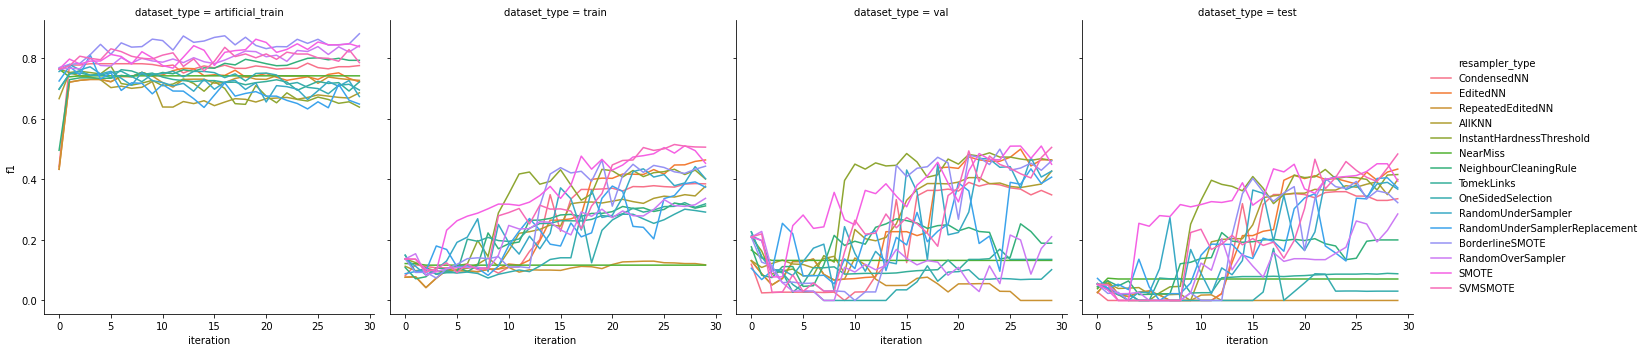

In [245]:
seaborn.relplot(data= results_imbalanced[results_imbalanced.model_type=='KNN'], x='iteration',y='f1', col='dataset_type', hue='resampler_type', kind='line')

In [241]:
pd.options.display.max_rows = 100

In [242]:
results_imbalanced[results_imbalanced.dataset_type=='test'].sort_values(by='f1',ascending=False).head(100)

,dataset_type,recall,precision,auroc,auprc,iteration,model_type,resampler_type,group,f1
3,test,0.638298,0.389610,0.390999,0.053003,29,KNN,SVMSMOTE,KNN_SVMSMOTE,0.483871
3,test,0.595745,0.383562,0.324824,0.048285,21,KNN,SVMSMOTE,KNN_SVMSMOTE,0.466667
3,test,0.595745,0.373333,0.385128,0.051378,24,KNN,SVMSMOTE,KNN_SVMSMOTE,0.459016
3,test,0.595745,0.363636,0.378893,0.051443,28,KNN,SMOTE,KNN_SMOTE,0.451613
3,test,0.595745,0.363636,0.380679,0.051523,27,KNN,SMOTE,KNN_SMOTE,0.451613
3,test,0.574468,0.369863,0.340123,0.049254,19,KNN,SMOTE,KNN_SMOTE,0.450000
3,test,0.595745,0.345679,0.380996,0.051300,28,KNN,SVMSMOTE,KNN_SVMSMOTE,0.437500
3,test,0.638298,0.329670,0.412472,0.053614,17,KNN,SMOTE,KNN_SMOTE,0.434783
3,test,0.595745,0.341463,0.292122,0.048371,29,KNN,EditedNN,KNN_EditedNN,0.434109
3,test,0.617021,0.333333,0.468040,0.059010,22,KNN,InstantHardnessThreshold,KNN_InstantHardnessThreshold,0.432836
